## 基于遗传学习的多输入多输出 ANC 系统设计

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import pyroomacoustics as pra
import IPython

### 一、不带滤波器的空间声音传播仿真

为了将算法与原始信号做对比，这里首先实现一个不包含滤波器的仿真情况。

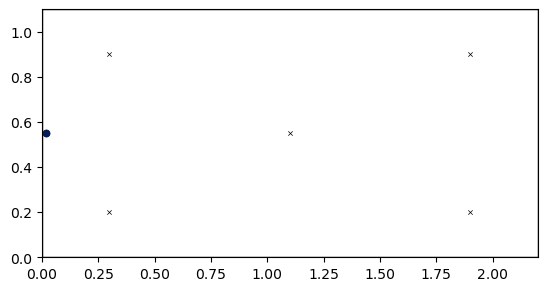

In [47]:
# 原始信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 将信号压缩为 200000
signal = signal[0:200000]

# 创建房间节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials) 参数进行设置，并生成新的 2D 房间 room 对象
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_sorce() 方法在 [0.02, 0.55] 处添加信号源头 signal
room.add_source([0.02, 0.55], signal=signal)

# 在房间的信号检测点处分布式添加五个误差信号 E
E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room.add_microphone(E)

# 使用 image_source_model() 类方法计算房间 room 的麦克风脉冲响应，并使用 simulate 方法进行房间仿真分析
room.image_source_model()
room.simulate()

# 绘制房间
fig, ax = room.plot()

下面输出原始信号与五个误差麦克风处的信号：

In [48]:
# 原始噪声信号
print("Original Wave:")
IPython.display.Audio(signal, rate=fs)

Original Wave:


下面输出五个误差麦克风的信号

In [49]:
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

In [50]:
IPython.display.Audio(room.mic_array.signals[1,:], rate=fs)

In [51]:
IPython.display.Audio(room.mic_array.signals[2,:], rate=fs)

In [52]:
IPython.display.Audio(room.mic_array.signals[3,:], rate=fs)

In [53]:
IPython.display.Audio(room.mic_array.signals[4,:], rate=fs)

### 二、声音的声压级

文献参考：[语音信号处理教程（二）声音的声压级和响度 - 腾讯云开发者社区-腾讯云](https://cloud.tencent.com/developer/article/1794094)

作为后续算法对比，这里需要先了解一下声音的声压级的概念。

#### 2.1 声压级的定义

声压级即所谓的声音有多少分贝，其定义为**声波在某一点处产生的逾量瞬时压强的均方根值**，它被作为描述声波大小的物理量。

声压级以符号`SPL (Sound Pressure Level)`表示，其定义将待测声压有效值$p_e$与参考声压$p_{ref}$的比值取常用对数，再乘以`20`，即：

$$SPL = 20 \lg \frac{p_e}{p_{ref}}$$

其中，声压有效值$p_e$就是一段声音的均方根 (RMS, Root Mean Square)，设语音长度为$T$，离散点数为$N$，则有效声压的计算公式可以表述为下面的公式：

$$P_e = \sqrt{\frac{1}{N} \sum_{n=1}^N x^2}$$

在空气中参考声压$p(ref)$一般取为`2e-5Pa`，这个数值是正常人耳朵对`800Hz`声音刚刚能够察觉其存在的声压值，即`800Hz`声音的可听阈声压。通常，低于这个声压，人耳就再也察觉不到这个声音了。显然，这个可听阈声压的声压级为`0`分贝 (dB)。

计算声音的声压级的代码如下所示：

/tmp/ipykernel_26554/2029195151.py:7: RuntimeWarning: invalid value encountered in sqrt
  pe = np.sqrt(np.sum(np.power(x, 2)) / Len)


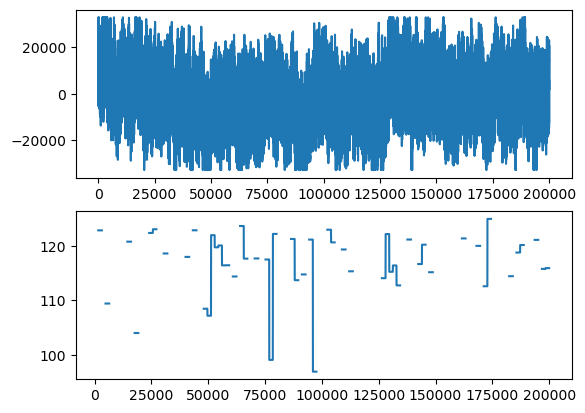

In [54]:
# 计算音频声压值的函数
def SPLCal(x):
    Len = len(x)    # 信号的长度
    # 参考声压
    p_ref = 2e-5
    # 输入信号的计算有效声压级，即求解 x 的 RMS
    pe = np.sqrt(np.sum(np.power(x, 2)) / Len)
    # 计算信号 x 的声压值
    spl = 20 * np.log10(pe / p_ref)

    return spl

# 下面计算输入噪声信号的声压值
Len = len(signal)   # 获得信号的长度
frameTime = 100
frameLen = fs * frameTime // 1000
m = np.mod(Len, frameLen)

if m >= frameLen / 2:
    signal = np.append(signal, np.zeros(int(frameLen-m)))
    Len = len(signal)

else:
    nframe = int(np.floor(Len / frameLen))
    signal = signal[0:nframe * frameLen + 1]
    Len = len(signal)

N = Len // frameLen
spl = np.array([])
for k in range(N):
    s = signal[k*frameLen : (k+1)*frameLen]
    spl = np.append(spl, SPLCal(s))

spl_rep = np.repeat(spl, frameLen)
plt.figure()
plt.subplot(211)
plt.plot(signal)

plt.subplot(212)
plt.plot(spl_rep)
plt.show()

### 三、多输入多输出的ANC设计

In [59]:
# 原始噪声信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 将信号缩短为 200000
signal = signal[0:200000]

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials) 参数进行设置，并生成新的 2D 房间 room 对象：
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_sorce() 方法在 [0.02, 0.55] 处添加信号源头 signal
room.add_source([0.02, 0.55], signal=signal)

# 在房间内部添加五个信号监测点： []
E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room.add_microphone(E)

# 对房间进行仿真
room.image_source_model()
room.simulate()

#####! 下面进行MIMO降噪算法设计 #####
# 设计降噪声滤波器的长度
length = 15

# 设置滤波器的维度为 4 * 15，其中行表示对应于五个误差麦克风的五个滤波器
w = np.random.randn(4, 15)
# 对滤波器参数进行范数正则化
w /= np.linalg.norm(w)

# 配置NLMS自适应滤波器
adfilt_nlms = dict(
    filter = pra.adaptive.NLMS(length, mu=0.5),
    error = np.zeros(200000),
)

for i in range(200000):
    # 以五个误差麦克风的均方误差 MSE_mic 为参考信号，对滤波器进行更新
    MSE_mic = np.sum([np.sum(room.mic_array.signals[j, i]) for j in [0, 1, 2, 3, 4]]) / len(room.mic_array.signals)

    # 下面使用 NLMS 自适应滤波器对滤波器 w 四行分别进行参数更新
    adfilt_nlms['filter'].update(signal[i], MSE_mic)
    # adfilt_nlms['error'][i] = np.linalg.norm(adfilt_nlms['filter'].w - w)

    

In [63]:
len(room.mic_array.signals)

5

下面以 pymoo 构建多目标优化模型，以实现多目标优化。

In [ ]:
from pymoo.core.problem import ElementwiseProblem

# 定义 ANC 优化问题
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=60,       # 一共四个滤波器分别对应于四个消声扬声器，每个滤波器长度为15
            n_obj=5,        # 对应五个误差麦克风的声音量
            xl=np.array([np.min(room.mic_array.signals[i]) for i in [0, 1, 2, 3, 4]]),
            xu=np.array([np.max(room.mic_array.signals[i]) for i in [0, 1, 2, 3, 4]])
        )

    def _evaluate(self, x, out, *args, **kwargs):

        # 得到五个误差麦克风处的信号
        E_mic1, E_mic2, E_mic3, E_mic4, E_mic5 = self.ANC_model(x)
        
        # 这里只需要将五个麦克风的信号作为目标函数即可，即使得五个误差麦克风处的噪声最小
        f1 = E_mic1
        f2 = E_mic2
        f3 = E_mic3
        f4 = E_mic4
        f5 = E_mic5
        f1 = [room.mic_array.signals[i]-fftconvolve(room.mic_array.signals[i], x[0:15]) for i in range(5)]

    def ANC_model(self, w):
        # 原始噪声信号
        fs, signal = wavfile.read('google_speech_commands/_background_noise_/pink_noise.wav')
        signal = signal[0:200000]       # 将信号缩短为 200000
        # 创建房间的节点
        corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T
        # 在房间内部添加五个信号监测点： []
        E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
        room.add_microphone(E)
        # 向房间中添加信号源，并创建一个 2D 空间，并设置空间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials)。
        room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))
        # 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
        room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
        
        for i in range(len(signal)):
            # 在 [0.02, 0.55] 处添加信号源 signal
            room.add_source([0.02, 0.55], signal=signal[i])
            
            # 对房间进行仿真
            room.image_source_model()
            room.simulate()
            
            # 在四个消噪声的地方添加噪声信号源头 ANM1, ANM2, ANM3, ANM4 (ANM, Anti-Noise Microphone)
            # 下面对每个误差麦克风信号进行卷积？还是对输入信号进行卷积？？？另外还需要搞清楚 fftconvolve() 输出的维度
            ANM_1 = fftconvolve(signal[i], w[0:15])
            ANM_2 = fftconvolve(signal[i], w[15:30])
            ANM_3 = fftconvolve(signal[i], w[30:45])
            ANM_4 = fftconvolve(signal[i], w[45:60])
            
            # 添加了信号源后执行一次仿真
            room.add_source([0.02, 1.08], signal=ANM_1)
            room.add_source([2.18, 1.08], signal=ANM_2)
            room.add_source([2.18, 0.02], signal=ANM_3)
            room.add_source([0.02, 0.02], signal=ANM_4)
            
            
        # 返回五个误差麦克风的信号
        return room.mic_array.signals[0], room.mic_array.signals[1], room.mic_array.signals[2], room.mic_array.signals[3], room.mic_array.signals[4]


In [95]:
a = np.array(range(10))
b = np.array(range(20))

temp = fftconvolve(b, a)
a = np.array(range(60))
print(a[0:15])
print(a[15:30])
print(a[30:45])
print(a[45:60])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]


In [74]:
len(signal)

200000

In [73]:
temp = [room.mic_array.signals[i] for i in range(5)]
temp

[array([-4.65661287e-11, -4.19095159e-11, -4.65661287e-12, ...,
        -4.65661287e-12, -1.16415322e-11, -1.86264515e-11]),
 array([-2.32830644e-12,  6.98491931e-12, -1.39698386e-11, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([ 3.25962901e-11,  1.86264515e-11,  0.00000000e+00, ...,
         2.32830644e-12, -3.25962901e-11, -4.65661287e-11]),
 array([-2.79396772e-11, -1.39698386e-11, -3.72529030e-11, ...,
         5.82076609e-12,  2.32830644e-12, -6.98491931e-12]),
 array([-1.16415322e-11,  1.39698386e-11,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00])]

使用 NSGA2 算法对优化问题进行求解

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size             = 40,      # 种群规模
    n_offspring          = 10,      # 生成的子代规模
    sampling             = FloatRandomSampling(),   # 随机抽样算子
    crossover            = SBX(prob=0.9, eta=15),   # 模拟二元交叉算子
    mutation             = PM(eta=20),              # 多项式突变算子
    eliminate_duplicates = True     # 去除重复的个体
)

